# Подключение библиотек и обработка данных
Более подробно о предобработке данных см. в файле credit_bad.py

In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from decimal import *

#  matplotlib.style.use('ggplot')
%matplotlib inline

In [54]:
credit_approved = pd.read_csv('data.csv', sep=',', decimal=",")
credit_approved.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5498546,0,0,40364,0,0,3000,560,0,0,...,0,0,0,0,0,3,50000,46,NaN,0
1,5498604,1500,0,23456,0,0,0,9999,0,0,...,0,0,0,0,0,3,35000,17,NaN,0
2,5498609,0.1,0,17999,3,0,9999,9999,0.1,9999,...,0,0,0,0,2,3,35000,58,NaN,0
3,5498645,5000,0,313247,0,0,0,9999,0,0,...,0,0,4923.97,0,0,5,35000,4,NaN,0
4,5498647,0,0,0,1,0,0,9999,0,0,...,0,0,0,0,0,5,35000,34,NaN,0


In [55]:
credit_approved = credit_approved.fillna(-1)
#credit_approved['bad'] = credit_approved['bad'].astype(int)

In [56]:
for column in credit.columns:
    if credit_approved[column].dtype == 'object':
        credit_approved[column] = pd.to_numeric(credit_approved[column])
    if credit_approved[column].dtype == 'float64':
        credit_approved[column] *= 10 ** (max([Decimal(str(i)).as_tuple().exponent*(-1) for i in credit_approved[column]]))
        credit_approved[column] = credit_approved[column].astype('int')

In [57]:
credit_approved = credit_approved.drop(['all_active_creds_sum_all'], axis = 1)

In [58]:
credit_approved = credit_approved.drop(['bad'], axis = 1)

<AxesSubplot: xlabel='approved', ylabel='count'>

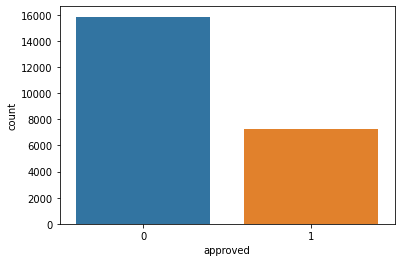

In [59]:
sns.countplot(x=credit['approved'])

In [60]:
credit_approved.shape

(23116, 23)

In [61]:
X = credit_approved.iloc[:, :-1].values  
y = credit_approved.iloc[:, 22].values 

In [62]:
from sklearn.model_selection import train_test_split  

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)

# KNN-classifier

In [64]:
#  Проведем стандартизацию предикторов

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_2 = scaler.transform(X_train)  
X_test_2 = scaler.transform(X_test) 

In [65]:
from sklearn.neighbors import KNeighborsClassifier  

#  Определяем оптимальное число ближайших соседей
#  Число ближайших соседей меняем от 1 до 15
#  Каждый раз считаем accuracy (долю правильных распознаваний)
#  error - доля ошибок при разных к

error_rate = [-1]*15  

for i in range(1, 16):  
    knn_res = KNeighborsClassifier(n_neighbors=i)
    knn_res.fit(X_train_2, y_train)
    pred_i = knn_res.predict(X_test_2)
    error_rate[i-1]= np.mean(pred_i != y_test)
    
print(np.round_(error_rate, 2))

[0.2  0.19 0.16 0.17 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.15 0.16
 0.16]


Text(0, 0.5, 'Доля ошибок')

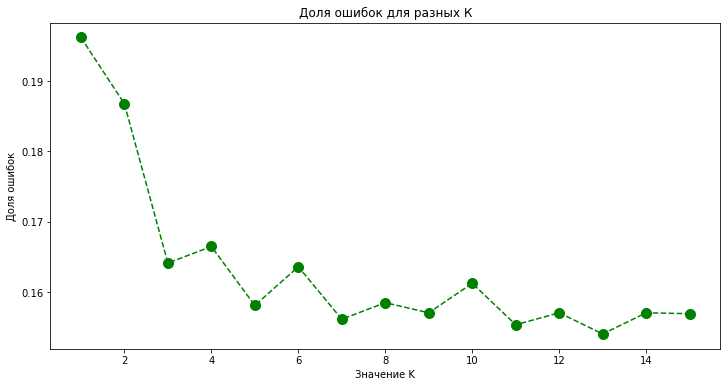

In [66]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 16), error_rate, color='green', linestyle='dashed', marker='o',  
         markerfacecolor='green', markersize=10)

plt.title(u'Доля ошибок для разных К')  
plt.xlabel(u'Значение K')  
plt.ylabel(u'Доля ошибок')

Нужно суметь правильно выбрать выбрать k так, чтобы минимизировать погрешность, и в то же время не рассматривать слишком большое значение

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {  
      'metric': ['minkowski','euclidean', 'chebyshev', 'cosine'],
      'leaf_size': [5, 10, 20, 30]
}

knn = KNeighborsClassifier(n_neighbors=5,       
        metric='minkowski', leaf_size=10)

grid_CV = GridSearchCV(knn, param_grid=param_grid, 
                               cv=2, 
                               scoring='accuracy')

grid_CV.fit(X_train_2, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(leaf_size=10),
             param_grid={'leaf_size': [5, 10, 20, 30],
                         'metric': ['minkowski', 'euclidean', 'chebyshev',
                                    'cosine']},
             scoring='accuracy')

In [68]:
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'leaf_size': 5, 'metric': 'cosine'}


In [69]:
knn = grid_CV.best_estimator_

In [70]:
y_train_pred = knn.predict(X_train_2)  
y_test_pred = knn.predict(X_test_2)

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [72]:
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat_train = pd.DataFrame(conf_mat, index=knn.classes_, columns=knn.classes_)

print(u'Таблица сопряженности для обучающей выборки')
print(conf_mat_train)  
print(' ')
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_train_pred, normalize=True))
print(' ')
print(classification_report(y_train, y_train_pred)) 

Таблица сопряженности для обучающей выборки
      0     1
0  9849   710
1  1111  3817
 
Accuracy на обучающей выборке 0.8824175114612255
 
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     10559
           1       0.84      0.77      0.81      4928

    accuracy                           0.88     15487
   macro avg       0.87      0.85      0.86     15487
weighted avg       0.88      0.88      0.88     15487



In [73]:
conf_mat = confusion_matrix(y_test, y_test_pred)
conf_mat_test = pd.DataFrame(conf_mat, index=knn.classes_, columns=knn.classes_)

print(u'Таблица сопряженности для тестовой выборки')
print(conf_mat_test)  
print(' ')
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_test_pred, normalize=True))
print(' ')
print(classification_report(y_test, y_test_pred))

Таблица сопряженности для тестовой выборки
      0     1
0  4793   495
1   709  1632
 
Accuracy на тестовой выборке 0.8421811508716739
 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5288
           1       0.77      0.70      0.73      2341

    accuracy                           0.84      7629
   macro avg       0.82      0.80      0.81      7629
weighted avg       0.84      0.84      0.84      7629



# Decision Tree Classifier

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
params_set = {
'max_depth': [4, 6, 7],
'min_samples_split': [8, 10, 12],
'min_samples_leaf': [4, 8, 10]
}

dtl = DecisionTreeClassifier(random_state=42,
                               max_depth=6,
                               min_samples_split=10,
                               min_samples_leaf=8)

grid_CV = GridSearchCV(estimator = dtl,
       param_grid = params_set,
       scoring = 'accuracy',
       cv = 5,
       n_jobs = -1)

grid_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=6, min_samples_leaf=8,
                                              min_samples_split=10,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 7], 'min_samples_leaf': [4, 8, 10],
                         'min_samples_split': [8, 10, 12]},
             scoring='accuracy')

In [76]:
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 8}


In [77]:
best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)  
y_pred_test = best_model.predict(X_test) 

conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat_train = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(u'Таблица сопряженности для обучающей выборки')
print(conf_mat_train)  
print(' ')
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(' ')
print(classification_report(y_train, y_pred_train)) 

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_test = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(' ')
print(u'Таблица сопряженности для тестовой выборки')
print(conf_mat_test) 
print(' ')
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(' ')
print(classification_report(y_test, y_pred_test))

Таблица сопряженности для обучающей выборки
      0     1
0  9680   879
1   812  4116
 
Accuracy на обучающей выборке 0.8908116484793698
 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     10559
           1       0.82      0.84      0.83      4928

    accuracy                           0.89     15487
   macro avg       0.87      0.88      0.87     15487
weighted avg       0.89      0.89      0.89     15487

 
Таблица сопряженности для тестовой выборки
      0     1
0  4820   468
1   411  1930
 
Accuracy на тестовой выборке 0.8847817538340542
 
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5288
           1       0.80      0.82      0.81      2341

    accuracy                           0.88      7629
   macro avg       0.86      0.87      0.87      7629
weighted avg       0.89      0.88      0.89      7629



In [78]:
pd.DataFrame({'feature': credit_approved.iloc[:, :-1].columns,
              'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
8,cred_sum_debt_all_all,0.450393
13,cred_day_overdue_all_sum_all,0.240955
12,all_creds_count_all,0.117563
9,all_closed_creds_sum_ly,0.046517
16,cred_sum_overdue_cc_all,0.037487
7,cred_sum_cc_ly,0.028939
11,delay_more_sum_all,0.019902
1,cred_sum_cc_all,0.017200
3,all_closed_creds_sum_all,0.011711
0,order_id,0.008867


По таблице видно, что большую значимость для выходного параметра (approved) вкладывают:
1. *cred_sum_debt_all_all* - сумма задолженности по всем кредитам 
2. *cred_day_overdue_all_sum_all* - cуммарное количество дней просрочки текущих активных кредитов

И почти ничего не значат параметры:
1. *cred_max_overdue_max_3lm* - максимальная сумма просроченной задолженности, по кредитам взятым за последние 3 месяца
2. *mfo_inqs_count_month* - количество запросов на кредиты в другие в МФО
3. *count_overdue_all_3lm* - количество кредитов на просрочке, взятых за последние 3 месяца
4. *work_code* - профессия
5. *region* - регион подачи заявки

То есть в основном параметры, которые не связаны ни с суммами ранее взятых кредитов, ни с количеством просроченных кредитов.

# Random Forest Classifier

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
param_grid = {  
      'n_estimators': [30, 40, 50, 100],
      'max_depth': [4, 5, 6],
      'max_features': [1, 3, 10],
      'min_samples_split': [3, 5, 10, 15],
}

rfc = RandomForestClassifier(random_state=42,
                               n_estimators=80,
                               max_depth=5,
                               min_samples_leaf=10, 
                               min_samples_split=15)

grid_CV = GridSearchCV(rfc, param_grid=param_grid, 
                               cv=2, 
                               scoring='accuracy')

grid_CV.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(max_depth=5, min_samples_leaf=10,
                                              min_samples_split=15,
                                              n_estimators=80,
                                              random_state=42),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [1, 3, 10],
                         'min_samples_split': [3, 5, 10, 15],
                         'n_estimators': [30, 40, 50, 100]},
             scoring='accuracy')

In [81]:
best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 6, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 100}


In [82]:
best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)  
y_pred_test = best_model.predict(X_test) 

conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat_train = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(u'Таблица сопряженности для обучающей выборки')
print(conf_mat_train)  
print(' ')
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(' ')
print(classification_report(y_train, y_pred_train)) 

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_test = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(' ')
print(u'Таблица сопряженности для тестовой выборки')
print(conf_mat_test) 
print(' ')
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(' ')
print(classification_report(y_test, y_pred_test))

Таблица сопряженности для обучающей выборки
      0     1
0  9850   709
1   800  4128
 
Accuracy на обучающей выборке 0.9025634403047718
 
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     10559
           1       0.85      0.84      0.85      4928

    accuracy                           0.90     15487
   macro avg       0.89      0.89      0.89     15487
weighted avg       0.90      0.90      0.90     15487

 
Таблица сопряженности для тестовой выборки
      0     1
0  4884   404
1   391  1950
 
Accuracy на тестовой выборке 0.8957923712151002
 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      5288
           1       0.83      0.83      0.83      2341

    accuracy                           0.90      7629
   macro avg       0.88      0.88      0.88      7629
weighted avg       0.90      0.90      0.90      7629



In [83]:
pd.DataFrame({'feature': credit_approved.iloc[:, :-1].columns,
              'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
8,cred_sum_debt_all_all,0.280851
13,cred_day_overdue_all_sum_all,0.195636
9,all_closed_creds_sum_ly,0.133429
18,all_creds_count_lm,0.062082
10,mfo_cred_mean_sum_3lm,0.053291
7,cred_sum_cc_ly,0.049405
12,all_creds_count_all,0.045409
16,cred_sum_overdue_cc_all,0.029801
15,mfo_closed_count_ly,0.027822
4,bank_inqs_count_quarter,0.023425


В целом ранжировка параметров по убыванию их значимости схожа с результатами DTC.

# Gradient Boosting Classifier

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

In [85]:
param_grid = {  
      'n_estimators': [400, 500, 450],
      'min_samples_leaf': [4, 5, 6],
      'max_depth': [4, 5, 6],
      'min_samples_split': [3, 5, 10, 15],
}

gbc = GradientBoostingClassifier(random_state=42,
                                   n_estimators=500,
                                   min_samples_leaf=5, 
                                   min_samples_split=10,
                                   max_depth=5,
                                   )

grid_CV = GridSearchCV(gbc, param_grid=param_grid, cv=2, 
                               scoring='accuracy')

grid_CV.fit(X_train, y_train)

best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 400}


In [86]:
best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)  
y_pred_test = best_model.predict(X_test) 

conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat_train = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(u'Таблица сопряженности для обучающей выборки')
print(conf_mat_train)  
print(' ')
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(' ')
print(classification_report(y_train, y_pred_train)) 

conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_test = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(' ')
print(u'Таблица сопряженности для тестовой выборки')
print(conf_mat_test) 
print(' ')
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(' ')
print(classification_report(y_test, y_pred_test))

Таблица сопряженности для обучающей выборки
       0     1
0  10245   314
1    417  4511
 
Accuracy на обучающей выборке 0.9527991218441273
 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10559
           1       0.93      0.92      0.93      4928

    accuracy                           0.95     15487
   macro avg       0.95      0.94      0.95     15487
weighted avg       0.95      0.95      0.95     15487

 
Таблица сопряженности для тестовой выборки
      0     1
0  4925   363
1   342  1999
 
Accuracy на тестовой выборке 0.907589461266221
 
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5288
           1       0.85      0.85      0.85      2341

    accuracy                           0.91      7629
   macro avg       0.89      0.89      0.89      7629
weighted avg       0.91      0.91      0.91      7629



# XGBoost Classifier

In [87]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [88]:
param_grid = {  
    'n_estimators': [100, 500, 800],
    'max_depth': [3, 5, 6]
}

xgbc = XGBClassifier(base_score=0.5, 
                        seed=1234, 
                        objective='binary:logistic',                         
                        learning_rate=0.1, 
                        silent=True,
                        use_label_encoder=False)

grid_CV = GridSearchCV(xgbc,
                               cv=5, 
                               error_score='raise',
                               param_grid = param_grid,
                               n_jobs=-1,
                               pre_dispatch='2*n_jobs', 
                               refit=True, 
                               scoring='accuracy', 
                               verbose=0)

le = LabelEncoder()
y_train = le.fit_transform(y_train)

grid_CV.fit(X_train, y_train)

best_hyperparams = grid_CV.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

[02:04:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Лучшие значения гиперпараметров:
 {'max_depth': 5, 'n_estimators': 100}


In [89]:
best_model = grid_CV.best_estimator_

y_pred_train = best_model.predict(X_train)  
y_pred_test = best_model.predict(X_test) 

conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat_train = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(u'Таблица сопряженности для обучающей выборки')
print(conf_mat_train)  
print(' ')
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(' ')
print(classification_report(y_train, y_pred_train)) 

Таблица сопряженности для обучающей выборки
       0     1
0  10069   490
1    539  4389
 
Accuracy на обучающей выборке 0.9335571769871505
 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10559
           1       0.90      0.89      0.90      4928

    accuracy                           0.93     15487
   macro avg       0.92      0.92      0.92     15487
weighted avg       0.93      0.93      0.93     15487



In [91]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [92]:
conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_test = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)

print(' ')
print(u'Таблица сопряженности для тестовой выборки')
print(conf_mat_test) 
print(' ')
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(' ')
print(classification_report(y_test, y_pred_test))

 
Таблица сопряженности для тестовой выборки
      0     1
0  4935   353
1   352  1989
 
Accuracy на тестовой выборке 0.907589461266221
 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5288
           1       0.85      0.85      0.85      2341

    accuracy                           0.91      7629
   macro avg       0.89      0.89      0.89      7629
weighted avg       0.91      0.91      0.91      7629



Оба последних метода дали одинаково высокий резльтат на тестовой выборке. Оба метода относятся к семейству бустинг методов